# 原生推理
## 单张图

In [ ]:
# from ultralytics import YOLO

# model = YOLO(best_model_path)
# path_image = 'datasets/lard/YoloFormat/train/images/BIRK_01_500_000.jpeg'
# pred = model.predict(
#     source=path_image, 
#     save=True, imgsz=640, conf=0.25, iou=0.7, visualize=True,
#     project='runs/ultralytics',
#     name=f'{exp_name}/predict',
# )

# predict实现

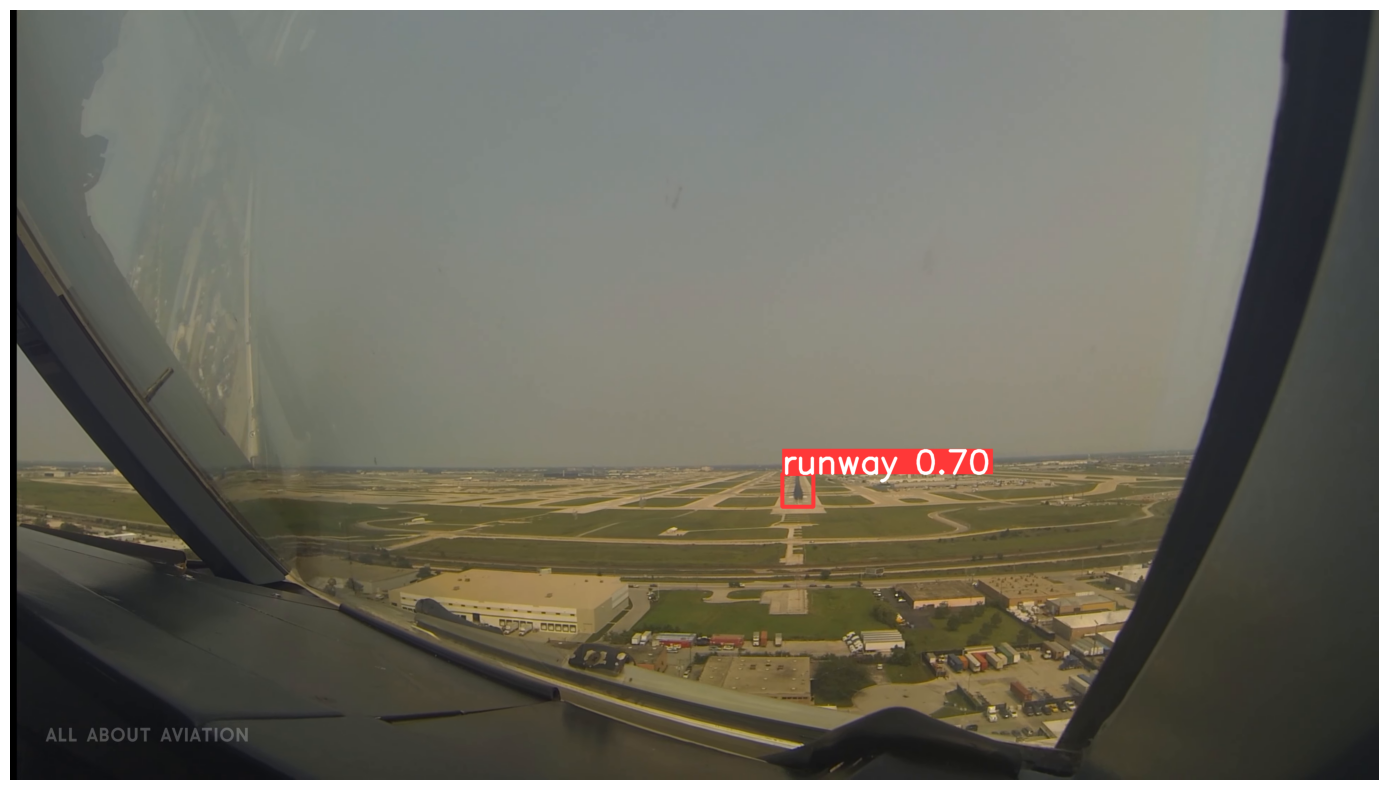

image 1/1 /home/yeli/workspace/lard/lard-detection/datasets/lard/detection/test_real_nominal/images/_lUpm8s55SA_082.png: 384x640 1 runway, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


In [3]:
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2


path_weights = 'runs/ultralytics/merge/yolov8n_lska_bifpn_EIoU_aug_all_5_640/train/weights/best.pt'
path_image = 'datasets/lard/detection/test_real_nominal/images/_lUpm8s55SA_082.png'

model = YOLO(path_weights)
results = model.predict(
    source=path_image,
    stream=True,  # 流式推理节省内存
    save=False, # 保存带检测结果的图像
    imgsz=640,
    conf=0.3,
    max_det=8,
    iou=0.6,
    device=0,
)

for r in results:
    img = r.plot()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 批量推理

In [10]:
! rm -r runs/ultralytics/vis

In [13]:
from ultralytics import YOLO
import torch

# 参数
project = 'runs/ultralytics/'

# 加载模型
models = [
    # {
    #     'model_name': 'base',
    #     'path_weights': 'runs/ultralytics/base/yolov8n_640/train/weights/best.pt'
    # },
    # {
    #     'model_name': 'proposed_640',
    #     'path_weights': 'runs/ultralytics/merge/yolov8n_lska_bifpn_EIoU_aug_all_5_640/train/weights/best.pt'
    # },
    {
        'model_name': 'proposed_finetune_640',
        'path_weights': 'runs/ultralytics/finetune/yolov8n_lska_bifpn_EIoU_aug_all_10_640/triple_split/train/weights/best.pt'
    },
]

for model in models:

    model_name = model['model_name']
    path_weights = model['path_weights']
    model = YOLO(path_weights)

    # 在各测试集进行推理
    # for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:
    for data_type in ['test_real_edge']:

        print(f'正在推理: {data_type}')
        data_file = f'datasets/lard/detection/{data_type}/images/'

        results = model.predict(
            source=data_file,
            stream=True,  # 流式推理节省内存
            save=True,  # 保存带检测结果的图像
            imgsz=1280,
            conf=0.1,
            max_det=3,
            iou=0.6,
            device=0,
            project=project,
            name=f'vis/{data_type}/{model_name}'
        )

        # 遍历迭代器
        for r in results:
            pass

# 晴空显存占用
torch.cuda.empty_cache()

正在推理: test_real_edge


image 1/311 /home/yeli/workspace/lard/lard-detection/datasets/lard/detection/test_real_edge/images/-PJP3pgLgjI_022.png: 736x1280 1 runway, 107.8ms
image 2/311 /home/yeli/workspace/lard/lard-detection/datasets/lard/detection/test_real_edge/images/-PJP3pgLgjI_025.png: 736x1280 1 runway, 5.7ms
image 3/311 /home/yeli/workspace/lard/lard-detection/datasets/lard/detection/test_real_edge/images/-PJP3pgLgjI_027.png: 736x1280 1 runway, 4.9ms
image 4/311 /home/yeli/workspace/lard/lard-detection/datasets/lard/detection/test_real_edge/images/-PJP3pgLgjI_029.png: 736x1280 1 runway, 4.9ms
image 5/311 /home/yeli/workspace/lard/lard-detection/datasets/lard/detection/test_real_edge/images/-PJP3pgLgjI_030.png: 736x1280 1 runway, 4.9ms
image 6/311 /home/yeli/workspace/lard/lard-detection/datasets/lard/detection/test_real_edge/images/-PJP3pgLgjI_031.png: 736x1280 1 runway, 4.9ms
image 7/311 /home/yeli/workspace/lard/lard-detection/datasets/lard/detection/test_real_edge/images/-PJP3pgLgjI_032.png: 736x1280

In [17]:
import os
from PIL import Image
import concurrent.futures
from tqdm import tqdm


# 路径定义
data_type = 'test_real_edge'
path1 = f'{project}/vis/{data_type}/base'
path2 = f'{project}/vis/{data_type}/proposed_finetune_6403'

# 都存在的文件
files1 = set(os.listdir(path1))
files2 = set(os.listdir(path2))
common_files = files1.intersection(files2)

# 输出路径
output_dir = f'{project}/vis/{data_type}/concatenated_images'
os.makedirs(output_dir, exist_ok=True)

# 水平拼接图像
def concatenate_images(file):
    img1 = Image.open(os.path.join(path1, file))
    img2 = Image.open(os.path.join(path2, file))
    
    # Ensure the images are the same height
    if img1.height != img2.height:
        new_height = min(img1.height, img2.height)
        img1 = img1.resize((img1.width, new_height))
        img2 = img2.resize((img2.width, new_height))
    
    # Create a new image with combined width
    combined_width = img1.width + img2.width
    new_height = img1.height  # Both images now have the same height
    new_img = Image.new('RGB', (combined_width, new_height))
    new_img.paste(img1, (0, 0))
    new_img.paste(img2, (img1.width, 0))
    
    # Save the concatenated image
    new_img.save(os.path.join(output_dir, file))
    return file

# 并行合并
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(concatenate_images, common_files), total=len(common_files)))



100%|██████████| 311/311 [00:15<00:00, 19.80it/s]


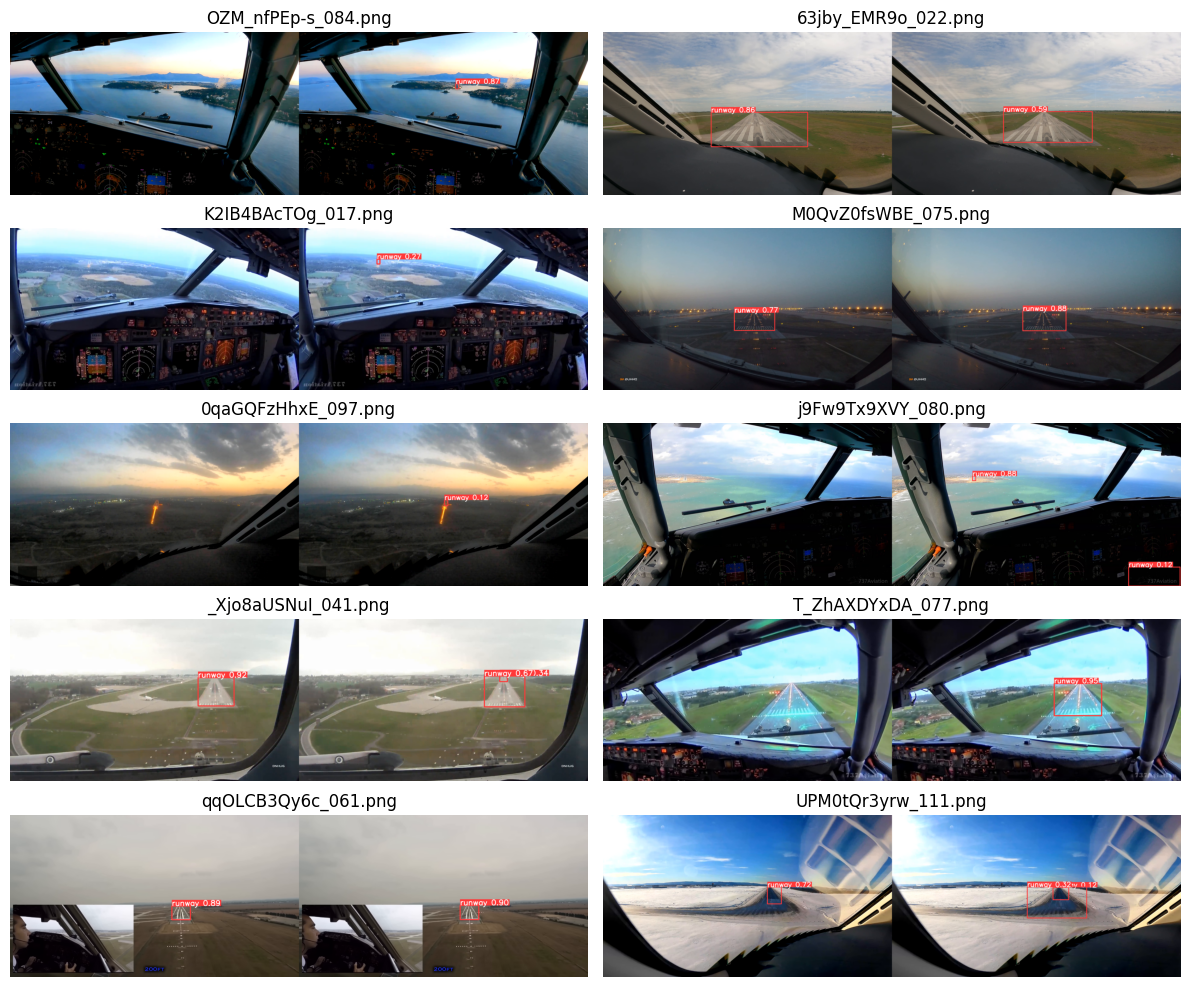

In [19]:
import os
import random
import matplotlib.pyplot as plt

# 随机选择10张图片
png_files = [os.path.join(output_dir, file) for file in os.listdir(output_dir)]
selected_files = random.sample(png_files, 10)

# 读取并显示图片
fig, axes = plt.subplots(5, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, img_path in zip(axes, selected_files):
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(os.path.basename(img_path))

plt.tight_layout()
plt.show()


# SAHI推理
## 单张图

In [ ]:
import cv2
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
from sahi.utils.file import save_json
import matplotlib.pyplot as plt


# 加载模型
path_weights = f'weights/yolov8n.pt'
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=path_weights,
    confidence_threshold=0.3,
    device='cpu')

# 读取图像
path_image = '3rdparty/ultralytics/ultralytics/assets/bus.jpg'
img = cv2.imread(path_image)
print(img.shape)

# 执行推理
results = get_sliced_prediction(
    img,
    detection_model,
    slice_height=1280,
    slice_width=1280,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)
# 结果持久化
save_json(results.to_coco_predictions(), 'predictions.json')

# 结果重构
object_prediction_list = results.object_prediction_list
boxes_list = []
clss_list = []
score_list = []
for ind, _ in enumerate(object_prediction_list):
    boxes = [
        object_prediction_list[ind].bbox.minx, object_prediction_list[ind].bbox.miny, 
        object_prediction_list[ind].bbox.maxx, object_prediction_list[ind].bbox.maxy
    ]
    clss = object_prediction_list[ind].category.name
    score = object_prediction_list[ind].score.value
    boxes_list.append(boxes)
    clss_list.append(clss)
    score_list.append(score)

# todo 转换为coco预测后用于误差评估
# # Convert to COCO annotation, COCO prediction, imantics, and fiftyone formats
# results.to_coco_annotations()[:3]
# results.to_coco_predictions(image_id=1)[:3]
# results.to_imantics_annotations()[:3]
# results.to_fiftyone_detections()[:3]

# 结果可视化
for box, cls, score in zip(boxes_list, clss_list, score_list):
    x1, y1, x2, y2 = box
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (56, 56, 255), 2)
    label = f"{cls}: {score:.2f}"
    t_size = cv2.getTextSize(label, 0, fontScale=0.6, thickness=1)[0]
    cv2.rectangle(img, (int(x1), int(y1) - t_size[1] - 3), (int(x1) + t_size[0], int(y1) + 3), (56, 56, 255), -1)
    cv2.putText(
        img,
        label, (int(x1), int(y1) - 2),
        0,
        0.6, [255, 255, 255],
        thickness=1,
        lineType=cv2.LINE_AA)

# 显示图片
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

## 批量推理

In [ ]:
model_type = "yolov8"
model_path = path_weights
model_device = "cpu" # or 'cuda:0'
model_confidence_threshold = 0.4

slice_height = 256
slice_width = 256
overlap_height_ratio = 0.2
overlap_width_ratio = 0.2

source_image_dir = "3rdparty/ultralytics/ultralytics/assets/"

results = predict(
    model_type=model_type,
    model_path=model_path,
    model_device=model_device,
    model_confidence_threshold=model_confidence_threshold,
    source=source_image_dir,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
)